In [138]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sb
import statsmodels.formula.api as smf 

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
 

from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score
from sklearn import linear_model,neighbors, tree, ensemble, metrics, cross_validation, externals, feature_selection, grid_search
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# The Data

In [63]:
df =pd.read_csv('school_data.csv', sep='\t',low_memory=False)
df.count()

Unnamed: 0               9046
CDSCode                  9046
County                   9046
District                 9046
School                   9046
Latitude                 9046
Longitude                9046
FundingType              1095
five_zip                 9046
type                     9046
charter                  1062
met_all                  9046
crit1                    9046
crit2                    9046
e_enr                    8908
e_tst                    8908
e_prof                   8908
m_enr                    8908
m_tst                    8908
m_prof                   8908
ee_aa                    8908
et_aa                    8908
enp_aa                   9046
me_aa                    8908
mt_aa                    8908
mnp_aa                   9046
ee_wh                    8908
et_wh                    8908
enp_wh                   9046
me_wh                    8908
                         ... 
ela_met                  9046
math_met                 9046
perc_crit 

In [64]:
df=df[['County','perc_crit','perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','any_virtual','perc_wh','perc_aa','perc_his','perc_as','success','m_pprof','e_pprof','above_avg']]
df0=df
df.count()

County                9046
perc_crit             9046
perc_staff_masters    7305
student_teacher       7305
avg_years_teaching    7305
total_enrollment      9046
Truancy_Rate          9046
median_income         9002
any_virtual           9046
perc_wh               9046
perc_aa               9046
perc_his              9046
perc_as               9046
success               9046
m_pprof               9046
e_pprof               9046
above_avg             9046
dtype: int64

# Feature Engineering

In [65]:
#drop all nulls (for now. may revisit this)
df=df.dropna()


### select features and target variable

In [66]:
names = ['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
y=df['m_pprof']
X.head()

,perc_staff_masters,student_teacher,avg_years_teaching,total_enrollment,Truancy_Rate,median_income,perc_wh,perc_aa,perc_his,perc_as,any_virtual
5,0.206897,21.724138,7.241379,597.0,51.428571,40894.8468,0.008375,0.197655,0.653266,0.020101,False
6,0.363636,21.363636,5.681818,437.0,43.191489,36648.5231,0.009153,0.064073,0.901602,0.004577,False
18,0.178571,19.892857,15.214286,519.0,12.208259,69600.5649,0.211946,0.067437,0.184971,0.319846,False
19,0.208333,21.458333,11.875000,486.0,1.553398,69600.5649,0.588477,0.018519,0.121399,0.135802,False
20,0.172414,21.379310,15.689655,588.0,3.387097,69600.5649,0.431973,0.028912,0.154762,0.192177,False


### correlation 

In [67]:
X.corr()

,perc_staff_masters,student_teacher,avg_years_teaching,total_enrollment,Truancy_Rate,median_income,perc_wh,perc_aa,perc_his,perc_as,any_virtual
perc_staff_masters,1.000000,0.074922,0.017831,0.085851,-0.040722,0.116581,0.023473,-0.005010,-0.039311,0.017787,0.025594
student_teacher,0.074922,1.000000,0.086782,0.219333,-0.014249,-0.078450,-0.181861,0.123258,0.137737,0.020077,-0.004013
avg_years_teaching,0.017831,0.086782,1.000000,-0.008715,-0.036640,0.015279,0.046800,-0.006445,-0.021556,-0.006016,-0.023285
total_enrollment,0.085851,0.219333,-0.008715,1.000000,0.151875,0.082043,-0.113304,0.011179,0.055869,0.112942,0.190144
Truancy_Rate,-0.040722,-0.014249,-0.036640,0.151875,1.000000,-0.191513,-0.188655,0.270919,0.174569,-0.183742,0.046604
median_income,0.116581,-0.078450,0.015279,0.082043,-0.191513,1.000000,0.360649,-0.120574,-0.502006,0.373198,-0.013060
perc_wh,0.023473,-0.181861,0.046800,-0.113304,-0.188655,0.360649,1.000000,-0.253825,-0.782358,-0.076242,0.033191
perc_aa,-0.005010,0.123258,-0.006445,0.011179,0.270919,-0.120574,-0.253825,1.000000,-0.068394,-0.062777,0.028125
perc_his,-0.039311,0.137737,-0.021556,0.055869,0.174569,-0.502006,-0.782358,-0.068394,1.000000,-0.420472,-0.009095
perc_as,0.017787,0.020077,-0.006016,0.112942,-0.183742,0.373198,-0.076242,-0.062777,-0.420472,1.000000,-0.034461


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135dbbd10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x144201450>]], dtype=object)

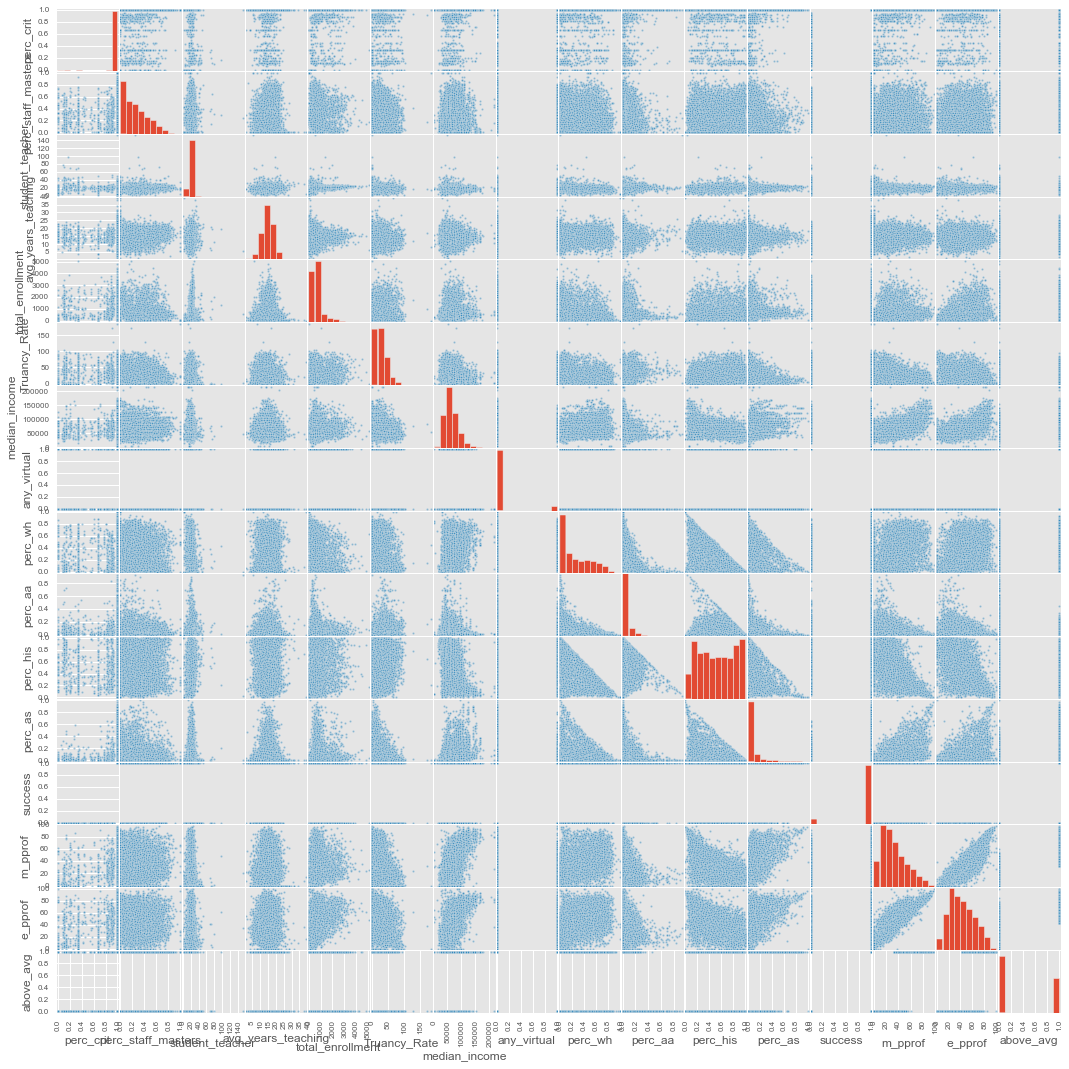

In [68]:
pd.scatter_matrix(df, figsize=(18, 18))

### interaction features 

In [69]:
df['income_wh']=df['median_income']*df['perc_wh']
df['income_his']=df['median_income']*df['perc_his']
df['income_truancy']=X['median_income']*df['Truancy_Rate']
X.head()

/Users/libbyalthea/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/libbyalthea/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/libbyalthea/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,perc_staff_masters,student_teacher,avg_years_teaching,total_enrollment,Truancy_Rate,median_income,perc_wh,perc_aa,perc_his,perc_as,any_virtual
5,0.206897,21.724138,7.241379,597.0,51.428571,40894.8468,0.008375,0.197655,0.653266,0.020101,False
6,0.363636,21.363636,5.681818,437.0,43.191489,36648.5231,0.009153,0.064073,0.901602,0.004577,False
18,0.178571,19.892857,15.214286,519.0,12.208259,69600.5649,0.211946,0.067437,0.184971,0.319846,False
19,0.208333,21.458333,11.875000,486.0,1.553398,69600.5649,0.588477,0.018519,0.121399,0.135802,False
20,0.172414,21.379310,15.689655,588.0,3.387097,69600.5649,0.431973,0.028912,0.154762,0.192177,False


### Scale variables

In [70]:
scaler = StandardScaler().fit(X)

In [71]:
Xs=scaler.transform(X)
# Will do this again for each model for selected features
#Xs=scaler.transform(X.as_matrix())

In [72]:
Xs

array([[-0.23809908,  0.21309744, -2.13784627, ...,  0.43223923,
        -0.44303444, -0.28338903],
       [ 0.52531109,  0.1396661 , -2.57220196, ...,  1.28979942,
        -0.56023437, -0.28338903],
       [-0.37605821, -0.1599201 ,  0.08269976, ..., -1.18489303,
         1.81994459, -0.28338903],
       ..., 
       [-0.38629047, -2.81005786, -2.00847684, ..., -0.73129219,
        -0.05552437, -0.28338903],
       [ 1.18947795, -0.90194156, -2.28050337, ...,  1.27926324,
        -0.55499917, -0.28338903],
       [-0.75874482, -0.19920359, -1.00747378, ..., -1.52817748,
        -0.59478664, -0.28338903]])

training and test sets

In [73]:
    X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)

# Regression 
## to predict the percenatage of students with math proficiency 

># Linear Regression

In [74]:
names = ['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
scaler = StandardScaler().fit(X)
y=df['m_pprof']
X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [75]:
X_train= pd.DataFrame(X_train,index=X_train[:,0])
X_train.columns = names
y_train = list(y_train)
X_train.head()

,perc_staff_masters,student_teacher,avg_years_teaching,total_enrollment,Truancy_Rate,median_income,perc_wh,perc_aa,perc_his,perc_as,any_virtual
-1.245801,-1.245801,-0.276081,-0.435178,-0.249368,-1.201280,0.953673,1.040634,-0.396997,-0.892502,-0.230785,-0.283389
1.189478,1.189478,1.447793,-0.185865,-0.127858,-0.886164,-0.933965,-1.073740,-0.031363,1.408230,-0.582688,3.528718
-0.445161,-0.445161,-1.796931,0.828031,1.246729,-1.192107,0.476979,1.979268,-0.169629,-1.390706,-0.449170,-0.283389
-0.550007,-0.550007,0.802768,0.885078,-0.422141,-0.605625,-0.135363,-0.947626,-0.106548,1.040554,-0.433813,-0.283389
-1.139919,-1.139919,0.689957,-1.290829,0.578422,-0.723451,-0.573897,-1.004888,-0.415147,1.411164,-0.541727,-0.283389


In [76]:
lin_model=smf.OLS(y_train,X_train).fit()
#model=smf.OLS(y_train,X_train).fit()
#model=linear_model.LinearRegression().fit(X_train,y_train) #sklearn

In [77]:
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 20 Sep 2016   Prob (F-statistic):          4.35e-217
Time:                        20:30:14   Log-Likelihood:                -24184.
No. Observations:                4866   AIC:                         4.839e+04
Df Residuals:                    4855   BIC:                         4.846e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
perc_staff_masters     0.4129      0.503      0.821      0.411        -0.573     1.398
student_teacher        0.1430      0.508      0.282      0.778        -0.852     1.138
avg_years_teaching     1.2930      0.497      2.602      0.009         0.319     2.267
total_enrollment       2.0704      0.534      3.874      0.000         1.023     3.118
Truancy_Rate          -3.4936      0.547     -6.391      0.000        -4.565    -2.422
median_income          5.3878      0.625      8.622      0.000         4.163     6.613
perc_wh                4.5906      2.112      2.173      0.030         0.450     8.731
perc_aa               -2.0989      0.936     -2.243      0.025        -3.934    -0.264
perc_his              -3.9588      2.288     -1.730      0.084        -8.445     0.528
perc_as                6.8888      1.275      5.402      0.000         4.389     9.389
any_virtual           -1.7389      0.512     -3.399      0.001        -2.742    -0.736
==============================================================================
Omnibus:                      118.674   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.173
Skew:                          -0.104   Prob(JB):                     1.43e-56
Kurtosis:                       4.107   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Trim features


In [78]:
names = ['avg_years_teaching','total_enrollment','Truancy_Rate','median_income',
         'perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
scaler = StandardScaler().fit(X)
y=df['m_pprof']
X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train= pd.DataFrame(X_train,index=X_train[:,0])
X_train.columns = names
y_train = list(y_train)
X_train.head()


,avg_years_teaching,total_enrollment,Truancy_Rate,median_income,perc_wh,perc_aa,perc_his,perc_as,any_virtual
-0.435178,-0.435178,-0.249368,-1.201280,0.953673,1.040634,-0.396997,-0.892502,-0.230785,-0.283389
-0.185865,-0.185865,-0.127858,-0.886164,-0.933965,-1.073740,-0.031363,1.408230,-0.582688,3.528718
0.828031,0.828031,1.246729,-1.192107,0.476979,1.979268,-0.169629,-1.390706,-0.449170,-0.283389
0.885078,0.885078,-0.422141,-0.605625,-0.135363,-0.947626,-0.106548,1.040554,-0.433813,-0.283389
-1.290829,-1.290829,0.578422,-0.723451,-0.573897,-1.004888,-0.415147,1.411164,-0.541727,-0.283389


In [79]:
lin_model=smf.OLS(y_train,X_train).fit()

In [80]:
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     129.3
Date:                Tue, 20 Sep 2016   Prob (F-statistic):          4.97e-219
Time:                        20:30:15   Log-Likelihood:                -24185.
No. Observations:                4866   AIC:                         4.839e+04
Df Residuals:                    4857   BIC:                         4.845e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
avg_years_teaching     1.3067      0.496      2.635      0.008         0.335     2.279
total_enrollment       2.1355      0.521      4.096      0.000         1.113     3.158
Truancy_Rate          -3.5195      0.543     -6.478      0.000        -4.585    -2.454
median_income          5.4373      0.621      8.754      0.000         4.220     6.655
perc_wh                4.5172      2.107      2.144      0.032         0.387     8.648
perc_aa               -2.0915      0.926     -2.260      0.024        -3.906    -0.277
perc_his              -4.0041      2.278     -1.757      0.079        -8.471     0.463
perc_as                6.8407      1.270      5.388      0.000         4.352     9.330
any_virtual           -1.7355      0.511     -3.393      0.001        -2.738    -0.733
==============================================================================
Omnibus:                      119.464   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.966
Skew:                          -0.101   Prob(JB):                     2.15e-57
Kurtosis:                       4.116   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### trim features again

In [81]:
names = ['avg_years_teaching','total_enrollment','Truancy_Rate','median_income',
         'perc_wh','perc_aa','perc_as','any_virtual']
X=df[names]
scaler = StandardScaler().fit(X)
y=df['m_pprof']
X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train= pd.DataFrame(X_train,index=X_train[:,0])
X_train.columns = names
y_train = list(y_train)

lin_model=smf.OLS(y_train,X_train).fit()
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     145.1
Date:                Tue, 20 Sep 2016   Prob (F-statistic):          1.85e-219
Time:                        20:30:15   Log-Likelihood:                -24186.
No. Observations:                4866   AIC:                         4.839e+04
Df Residuals:                    4858   BIC:                         4.844e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
avg_years_teaching     1.2438      0.495      2.515      0.012         0.274     2.214
total_enrollment       2.0847      0.521      4.004      0.000         1.064     3.105
Truancy_Rate          -3.5232      0.543     -6.483      0.000        -4.589    -2.458
median_income          5.6035      0.614      9.126      0.000         4.400     6.807
perc_wh                8.0764      0.581     13.907      0.000         6.938     9.215
perc_aa               -0.7697      0.540     -1.426      0.154        -1.828     0.288
perc_as                8.8374      0.567     15.588      0.000         7.726     9.949
any_virtual           -1.7672      0.511     -3.457      0.001        -2.769    -0.765
==============================================================================
Omnibus:                      116.957   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.294
Skew:                          -0.094   Prob(JB):                     3.66e-56
Kurtosis:                       4.106   Cond. No.                         2.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
#scrap work trying to add names 

#type(X_train)
#X_train.dtype.names= ('perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual') 
#X_train.shape
#X_train[1:]
#type(X_train)
#a.dtype.names = ('c', 'd')
#X_train.dtype.names = ('perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual') 

#X_train.columns=X[:0]
#X_train.columns = ['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']

#model=smf.OLS(y_train,X_train).fit()
#model=linear_model.LinearRegression().fit(X_train,y_train) #sklearn

#7263
#X_train[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

#X_train[['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']]= scaler.fit_transform(X[['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']])
#dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

#X_train[['perc_staff_masters','student_teacher']]=scaler.fit_transform(X[['perc_staff_masters','student_teacher']])



### add interaction effect features

In [134]:
names = ['income_wh','income_his','income_truancy','avg_years_teaching','total_enrollment',
         'Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
scaler = StandardScaler().fit(X)
y=df['m_pprof']
X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train= pd.DataFrame(X_train,index=X_train[:,0])
X_train.columns = names
y_train = list(y_train)

lin_model=smf.OLS(y_train,X_train).fit()

print "Linear Regression"
print names
lin_model.summary()


Linear Regression
['income_wh', 'income_his', 'income_truancy', 'avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     101.5
Date:                Tue, 20 Sep 2016   Prob (F-statistic):          2.03e-225
Time:                        22:47:23   Log-Likelihood:                -24163.
No. Observations:                4866   AIC:                         4.835e+04
Df Residuals:                    4854   BIC:                         4.843e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
income_wh              5.8426      2.891      2.021      0.043         0.175    11.511
income_his            -4.8574      1.986     -2.446      0.014        -8.750    -0.965
income_truancy        -0.6560      1.588     -0.413      0.680        -3.769     2.457
avg_years_teaching     1.2862      0.494      2.605      0.009         0.318     2.254
total_enrollment       1.9870      0.521      3.817      0.000         0.966     3.008
Truancy_Rate          -2.9911      1.528     -1.958      0.050        -5.986     0.004
median_income          5.6002      2.397      2.336      0.020         0.901    10.299
perc_wh               -2.1481      3.244     -0.662      0.508        -8.507     4.211
perc_aa               -2.8872      0.939     -3.073      0.002        -4.729    -1.046
perc_his              -1.7492      3.218     -0.543      0.587        -8.059     4.560
perc_as                5.4905      1.291      4.255      0.000         2.961     8.020
any_virtual           -1.5696      0.510     -3.078      0.002        -2.569    -0.570
==============================================================================
Omnibus:                      163.751   Durbin-Watson:                   0.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              457.579
Skew:                          -0.032   Prob(JB):                    4.35e-100
Kurtosis:                       4.501   Cond. No.                         21.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Cross validate  sklearn linear model

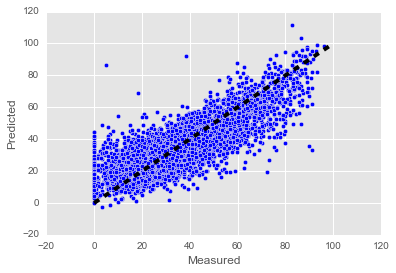

In [84]:
ln= linear_model.LinearRegression()
predicted=cross_val_predict(ln, X_train, y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_train, predicted)
ax.plot([0, 100], [0, 100], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [85]:
lin_model=ln.fit(X_train,y_train)
print lin_model.coef_
print "training score", lin_model.score(X_train,y_train)
print "test score", lin_model.score(X_test,y_test)
print feature_selection.f_regression(X_train, y_train)[1]

[ 5.11116753 -3.53256849 -0.82302533  1.08656455  1.68076888 -2.33628649
  5.78947808 -1.79604184 -2.77197457 -3.26754814  5.32349654 -1.67045363]
training score 0.693847803612
test score 0.709050255433
[  0.00000000e+000   2.09548150e-251   8.83828602e-004   1.58116466e-006
   2.02057028e-007   9.31033205e-134   0.00000000e+000   3.53582867e-293
   5.01164229e-056   0.00000000e+000   0.00000000e+000   4.24789113e-008]


In [86]:
#model=smf.OLS(y_train,X_train).fit()
#model.pvalues()
#cross_validation.cross_val_score(ln_model, X_train, y_train, cv = 10).mean()

#from sklearn.linear_model import LinearRegression
#lm = LinearRegression()
#lm.fit(X_train, y_train)
#lm.score(X_train,y_train)


#lr = linear_model.LinearRegression()
#boston = datasets.load_boston()
#y = boston.target

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:


# Classification 
## to predict "above average"  (above average in math and above average in English)

># Logistic Regression

In [170]:
names=['avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
y=df['above_avg'] 
names_X = ['avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [171]:
log_model=linear_model.LogisticRegression().fit(X_train,y_train)
print names
print log_model.coef_
print log_model.intercept_
print 'training misclassification =', 1 - log_model.score(X_train, y_train)
#print 'testing  misclassification =', 1 - log_model.score(X_test, y_test)

['avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']
[[ 0.22261804  0.43330788 -0.58718287  1.05014712  0.44901018 -0.37163929
  -0.94340533  0.80878824 -0.22221041]]
[-0.75185316]
training misclassification = 0.149609535553


In [160]:
names=['total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as']
X=df[names]
y=df['above_avg'] 
names_X = ['avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=42)
log_model2=linear_model.LogisticRegression().fit(X_train2,y_train2)
print names
print log_model2.coef_
print log_model2.intercept_
print 'training misclassification =', 1 - log_model2.score(X_train2, y_train2)
#print 'testing  misclassification =', 1 - log_model.score(X_test, y_test)

 ['total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as']
[[ 0.37715473 -0.56808171  1.04678901  0.46227647 -0.37125575 -0.89745737
   0.830557  ]]
[-0.73506389]
training misclassification = 0.15269214961


### choose optimal c value

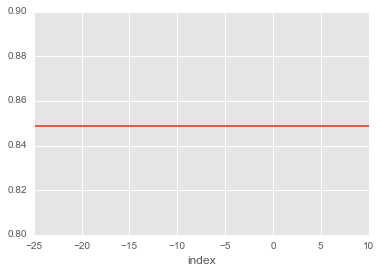

In [149]:
c_df = pd.DataFrame({'index': np.linspace(-25, 10, 30)})

c_df['c'] = c_df['index'].apply(lambda index: 10 ** index)

def optimize_c(c):
    model = linear_model.LogisticRegression(C = c)
    return cross_validation.cross_val_score(log_model, X_train, y_train, cv = 10).mean()

c_df['Score'] = c_df.c.apply(optimize_c)

c_df.set_index('index').Score.plot()

In [133]:
print "Logist Regression"
print names
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(linear_model.LogisticRegression(), X_train, np.ravel(y_train), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"

#F1 
cv_scores_f1 = cross_val_score(linear_model.LogisticRegression(), X_train, np.ravel(y_train), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(linear_model.LogisticRegression(), X_train, np.ravel(y_train), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(linear_model.LogisticRegression(), X_train, np.ravel(y_train), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

Logist Regression
['avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.84804928  0.85420945  0.84188912  0.85010267  0.81519507  0.84188912
  0.85802469  0.85596708  0.85596708  0.86419753]
Accuracy Score mean
0.848549108086

________________________________________________________________________________________________ 

F1 Scores
[ 0.80628272  0.80862534  0.7890411   0.79778393  0.74285714  0.7867036
  0.80779944  0.80874317  0.80662983  0.81868132]
F1 mean
0.797314759805

________________________________________________________________________________________________ 

Recall Scores
[ 0.82352941  0.80213904  0.77005348  0.77005348  0.69518717  0.75935829
  0.77956989  0.79569892  0.78494624  0.80107527]
Recall mean
0.77816111782

_____________________________________________________

In [172]:
print "Logist Regression"
print names
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(linear_model.LogisticRegression(), X_test, np.ravel(y_test), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"

#F1 
cv_scores_f1 = cross_val_score(linear_model.LogisticRegression(), X_test, np.ravel(y_test), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(linear_model.LogisticRegression(), X_test, np.ravel(y_test), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(linear_model.LogisticRegression(), X_test, np.ravel(y_test), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

Logist Regression
['avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.86721992  0.85892116  0.86666667  0.83333333  0.85833333  0.87083333
  0.80753138  0.87447699  0.82845188  0.88284519]
Accuracy Score mean
0.854861318484

________________________________________________________________________________________________ 

F1 Scores
[ 0.82608696  0.8045977   0.82222222  0.77011494  0.80898876  0.82080925
  0.72941176  0.82954545  0.74846626  0.8313253 ]
F1 mean
0.799156861315

________________________________________________________________________________________________ 

Recall Scores
[ 0.84444444  0.77777778  0.82222222  0.74444444  0.8         0.78888889
  0.69662921  0.82022472  0.68539326  0.7752809 ]
Recall mean
0.775530586767

___________________________________________________

In [153]:
y_hat = log_model.predict(X_test)
results=pd.DataFrame({'Observed': y_test, 'Predicted': y_hat})
pd.crosstab(results.Predicted,results.Observed, rownames=['above avg'])


Observed,False,True
above avg,,
False,1351,195
True,151,701


In [92]:
y_test_prob=log_model.predict_proba(X_test)[:,1]

In [93]:
roc_test=roc_curve(y_test,y_test_prob)

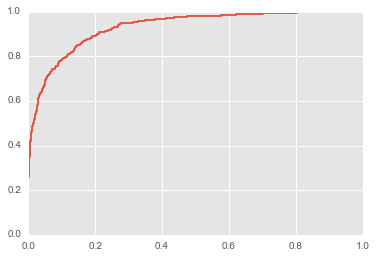

In [94]:
plt.plot(roc_test[0],roc_test[1])
plt.plot([0,0], [1,1], "--")
plt.show()

># K-nearest neighbors

predicting met all testing criteria :

In [95]:
X=df[['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']]
y=df['success']
scaler = StandardScaler().fit(X)
Xs=scaler.transform(X)
Xs.shape
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)

In [96]:
model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
model.fit(X_train, y_train)
model.fit 
#X=df[['perc_staff_masters','student_teacher']]

#X.head()
#y.head()

<bound method KNeighborsClassifier.fit of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')>

In [97]:
y_hat = model.predict(X_train)

results=pd.DataFrame({'Observed': y_train, 'Predicted': y_hat})

(results.Predicted == results.Observed).mean()


0.93033292231812581

In [98]:
df.above_avg.value_counts()

False    4502
True     2762
Name: above_avg, dtype: int64

### K-nearest neighbors to predict above avg

In [108]:
print "K-nearest Neighbors"

X=df[['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']]
y=df['above_avg']
#scaler = StandardScaler().fit(X)
#Xs=scaler.transform(X)
#Xs.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
model.fit(X_train, y_train)
model.fit 
#X=df[['perc_staff_masters','student_teacher']]

#X.head()
#y.head()
y_hat = model.predict(X_train)

results=pd.DataFrame({'Observed': y_train, 'Predicted': y_hat})

print "percent correct: ", (results.Predicted == results.Observed).mean()


accuracy = model.score(X, y)
misclassification_error = 1 - accuracy

print "misclassification error: ", misclassification_error



K-nearest Neighbors
percent correct:  0.831483764899
misclassification error:  0.192868942731


In [109]:
print "K-nearest Neighbors"
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"

#F1 
cv_scores_f1 = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

K-nearest Neighbors

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.76591376  0.75359343  0.74948665  0.74948665  0.76180698  0.76386037
  0.78600823  0.75925926  0.76748971  0.80452675]
Accuracy Score mean
0.766143179456

________________________________________________________________________________________________ 

F1 Scores
[ 0.67613636  0.67032967  0.64942529  0.65536723  0.67955801  0.67787115
  0.69942197  0.68119891  0.68347339  0.74114441]
F1 mean
0.681392639139

________________________________________________________________________________________________ 

Recall Scores
[ 0.63636364  0.65240642  0.60427807  0.62032086  0.65775401  0.64705882
  0.65053763  0.67204301  0.65591398  0.7311828 ]
Recall mean
0.652785923754

________________________________________________________________________________________________ 

Precision Scores
[ 0.72121212  0.68926554  0.70186335  0.69461078  0.70285714  0.71176

In [100]:

pd.crosstab(results.Predicted,results.Observed, rownames=['above avg'])

Observed,False,True
above avg,,
False,2675,495
True,325,1371


In [101]:
y.mean()


0.38023127753303965

K-nearest neighbors to predict above avg trim features

In [168]:
X=df[['perc_staff_masters','student_teacher','avg_years_teaching','Truancy_Rate','median_income','perc_wh','perc_as']]
y=df['above_avg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
model.fit(X_train, y_train)
model.fit 
#X=df[['perc_staff_masters','student_teacher']]

#X.head()
#y.head()
y_hat = model.predict(X_train)

results=pd.DataFrame({'Observed': y_train, 'Predicted': y_hat})

print "percent correct: ", (results.Predicted == results.Observed).mean()

accuracy = model.score(X, y)
misclassification_error = 1 - accuracy

print "model score: ", accuracy 
print "misclassification error: ", misclassification_error


percent correct:  0.846485819975
model score:  0.825853524229
misclassification error:  0.174146475771


In [113]:
print "K-nearest Neighbors"
print 'perc_staff_masters','student_teacher','avg_years_teaching','Truancy_Rate','median_income','perc_wh','perc_as'
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"

#F1 
cv_scores_f1 = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(neighbors.KNeighborsClassifier(), X_train, np.ravel(y_train), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

K-nearest Neighbors
perc_staff_masters student_teacher avg_years_teaching Truancy_Rate median_income perc_wh perc_as

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.78234086  0.79671458  0.76180698  0.76591376  0.7926078   0.78234086
  0.77983539  0.79835391  0.79218107  0.82510288]
Accuracy Score mean
0.787719809702

________________________________________________________________________________________________ 

F1 Scores
[ 0.70224719  0.72727273  0.68648649  0.68156425  0.71225071  0.69886364
  0.68985507  0.72777778  0.71549296  0.76584022]
F1 mean
0.710765102757

________________________________________________________________________________________________ 

Recall Scores
[ 0.6684492   0.70588235  0.67914439  0.65240642  0.6684492   0.65775401
  0.63978495  0.70430108  0.6827957   0.74731183]
Recall mean
0.680627910988

________________________________________________________________________________________

In [169]:
print "K-nearest Neighbors"
print 'perc_staff_masters','student_teacher','avg_years_teaching','Truancy_Rate','median_income','perc_wh','perc_as'
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(neighbors.KNeighborsClassifier(), X_test, np.ravel(y_test), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"

#F1 
cv_scores_f1 = cross_val_score(neighbors.KNeighborsClassifier(), X_test, np.ravel(y_test), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(neighbors.KNeighborsClassifier(), X_test, np.ravel(y_test), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(neighbors.KNeighborsClassifier(), X_test, np.ravel(y_test), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

K-nearest Neighbors
perc_staff_masters student_teacher avg_years_teaching Truancy_Rate median_income perc_wh perc_as

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.76763485  0.73858921  0.75        0.74583333  0.74166667  0.74166667
  0.72384937  0.75732218  0.76987448  0.78242678]
Accuracy Score mean
0.75188635364

________________________________________________________________________________________________ 

F1 Scores
[ 0.68888889  0.64804469  0.64705882  0.63905325  0.62195122  0.64367816
  0.62921348  0.66666667  0.66666667  0.70786517]
F1 mean
0.655908702504

________________________________________________________________________________________________ 

Recall Scores
[ 0.68888889  0.64444444  0.61111111  0.6         0.56666667  0.62222222
  0.62921348  0.65168539  0.61797753  0.70786517]
Recall mean
0.634007490637

_________________________________________________________________________________________

In [104]:
pd.crosstab(results.Predicted,results.Observed, rownames=['above avg'])

Observed,False,True
above avg,,
False,2769,346
True,231,1520


In [105]:
k_cv = 10 # 10-fold CV
k_nn = range(1, len(df) * (k_cv - 1) / k_cv) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn},
    cv = cross_validation.KFold(len(df), n_folds = k_cv)
)

gs.fit(X, y)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'Score': [score.mean_validation_score for score in gs.grid_scores_]})

score_df

KeyboardInterrupt: 

In [ ]:
score_df[score_df.Score == score_df.Score.max()]

># Decision Tree

In [177]:
names=['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
y=df['above_avg']
scaler = StandardScaler().fit(X)
Xs=scaler.transform(X)
Xs.shape
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)


#dt_model = tree.DecisionTreeClassifier(random_state = 0).\
 #   fit(X_train, y_train)
    
dt_model = tree.DecisionTreeClassifier(random_state = 0,min_samples_leaf=250,max_leaf_nodes=1000).fit(X_train, y_train)

In [178]:
print pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X.columns).sort(['Imp'], ascending = False)

                         Imp
perc_his            0.707427
median_income       0.171572
perc_as             0.051899
perc_aa             0.042432
Truancy_Rate        0.026576
avg_years_teaching  0.000094
perc_staff_masters  0.000000
student_teacher     0.000000
total_enrollment    0.000000
perc_wh             0.000000
any_virtual         0.000000


/Users/libbyalthea/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [179]:
print "Decision Tree"
print names
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(tree.DecisionTreeClassifier(), X_train, np.ravel(y_train), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"


#F1 
cv_scores_f1 = cross_val_score(tree.DecisionTreeClassifier(), X_train, np.ravel(y_train), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(tree.DecisionTreeClassifier(), X_train, np.ravel(y_train), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(tree.DecisionTreeClassifier(), X_train, np.ravel(y_train), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

Decision Tree
['perc_staff_masters', 'student_teacher', 'avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.80492813  0.79671458  0.77002053  0.79055441  0.79671458  0.80492813
  0.81893004  0.78806584  0.79835391  0.81069959]
Accuracy Score mean
0.797990975233

________________________________________________________________________________________________ 

F1 Scores
[ 0.72679045  0.74680307  0.70619946  0.77083333  0.71309192  0.76470588
  0.75        0.70899471  0.73994638  0.77866667]
F1 mean
0.740603187495

________________________________________________________________________________________________ 

Recall Scores
[ 0.73262032  0.74331551  0.71657754  0.79144385  0.67379679  0.73796791
  0.7311828   0.72580645  0.76344086  0.79032258]
Recall mean
0.740647461331

______________

In [180]:
print "Decision Tree"
print names
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"


#F1 
cv_scores_f1 = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

Decision Tree
['perc_staff_masters', 'student_teacher', 'avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.83817427  0.80082988  0.80416667  0.79583333  0.80416667  0.85416667
  0.79916318  0.81171548  0.84100418  0.78661088]
Accuracy Score mean
0.813583120656

________________________________________________________________________________________________ 

F1 Scores
[ 0.77659574  0.75935829  0.77348066  0.69879518  0.73033708  0.78021978
  0.72527473  0.79120879  0.79069767  0.71111111]
F1 mean
0.753707903804

________________________________________________________________________________________________ 

Recall Scores
[ 0.83333333  0.75555556  0.8         0.65555556  0.76666667  0.76666667
  0.75280899  0.83146067  0.74157303  0.73033708]
Recall mean
0.763395755306

______________

In [181]:
features = list(X.columns)
features

['perc_staff_masters',
 'student_teacher',
 'avg_years_teaching',
 'total_enrollment',
 'Truancy_Rate',
 'median_income',
 'perc_wh',
 'perc_aa',
 'perc_his',
 'perc_as',
 'any_virtual']

In [182]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [183]:
#to export visual:
visualize_tree(dt_model, features)

In [184]:
#%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py
%load_ext gvmagic

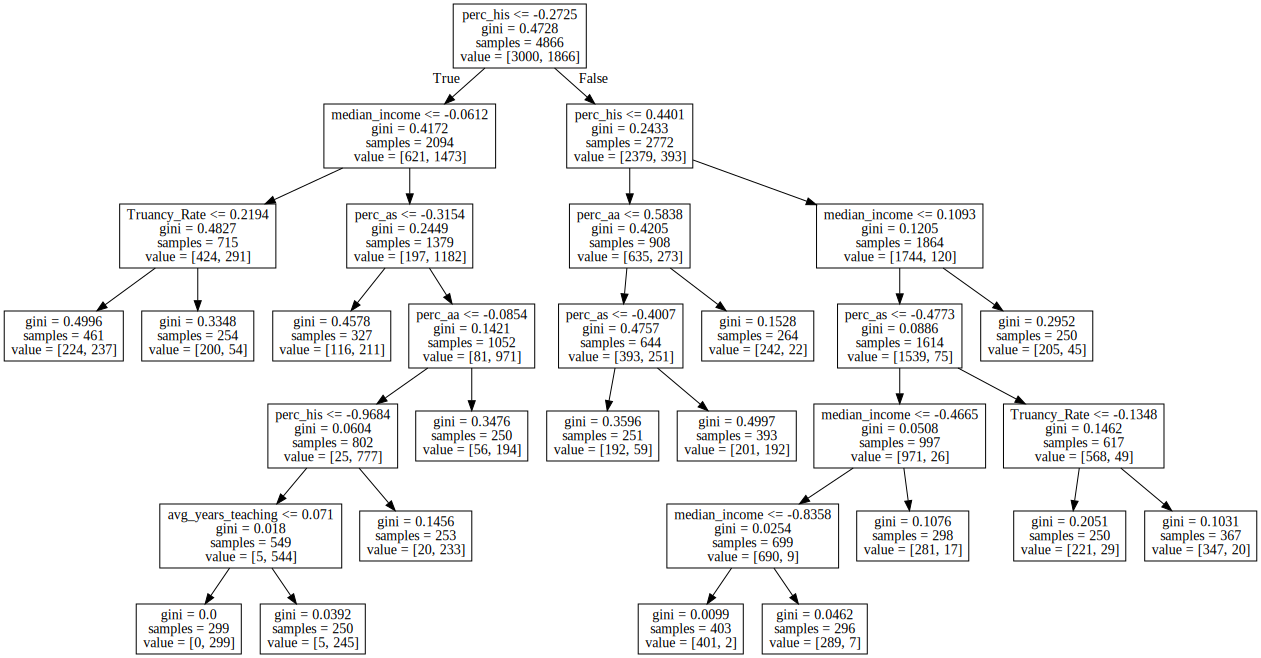

In [185]:
dot_data = externals.six.StringIO()
tree.export_graphviz(dt_model, out_file = dot_data, feature_names = X.columns)
%dotstr dot_data.getvalue()

In [186]:
cross_validation.cross_val_score(dt_model, X_train, y_train, cv = 10).mean()

0.81463693901521883

In [ ]:
cross_validation.cross_val_score(dt_model, X_test, y_test, cv = 10).mean()

In [ ]:
leaf = range(5,7) # k-NN
leaf_score=[]
for i in leaf:
    model= dt_model = tree.DecisionTreeClassifier(random_state = 0,min_samples_leaf=250,max_leaf_nodes=i).fit(X_train, y_train)
    score=cross_validation.cross_val_score(rf_model, X_train, y_train, cv = 10).mean()
    leaf_score.append(score)
    print "for", i, "leaves the score is",score

># Random Forest

In [162]:
names=['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=df[names]
y=df['above_avg']
scaler = StandardScaler().fit(X)
Xs=scaler.transform(X)
Xs.shape
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)


rf_model = ensemble.RandomForestClassifier(n_estimators = 1000,
        min_samples_leaf = 10,
        oob_score = True,
        random_state = 0).\
    fit(X_train, y_train)

In [120]:
sorted(zip(rf_model.feature_importances_, X.columns.values), reverse = True)

[(0.28580687243153535, 'perc_his'),
 (0.21280539347851432, 'median_income'),
 (0.15294802238285582, 'perc_as'),
 (0.13476253850724768, 'perc_wh'),
 (0.061723607464889405, 'Truancy_Rate'),
 (0.047873579639683563, 'perc_aa'),
 (0.043412709485369259, 'total_enrollment'),
 (0.022741045230313367, 'avg_years_teaching'),
 (0.019445354769167377, 'student_teacher'),
 (0.017773196299514231, 'perc_staff_masters'),
 (0.00070768031090958749, 'any_virtual')]

In [121]:
cross_validation.cross_val_score(rf_model, X_train, y_train, cv = 10).mean()

0.86169459443472662

In [122]:
cross_validation.cross_val_score(rf_model, X_test, y_test, cv = 10).mean()

0.8632085988182665

In [163]:
print "Random Forst"
print names
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(ensemble.RandomForestClassifier(), X_train, np.ravel(y_train), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"


#F1 
cv_scores_f1 = cross_val_score(ensemble.RandomForestClassifier(), X_train, np.ravel(y_train), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(ensemble.RandomForestClassifier(), X_train, np.ravel(y_train), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(ensemble.RandomForestClassifier(), X_train, np.ravel(y_train), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()
    

Random Forst
['perc_staff_masters', 'student_teacher', 'avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.85831622  0.86447639  0.85420945  0.83778234  0.84188912  0.83572895
  0.86213992  0.84567901  0.83333333  0.86213992]
Accuracy Score mean
0.849569464514

________________________________________________________________________________________________ 

F1 Scores
[ 0.81792717  0.82352941  0.78034682  0.77363897  0.77936963  0.8121547
  0.79402985  0.8         0.78062678  0.8252149 ]
F1 mean
0.798683822665

________________________________________________________________________________________________ 

Recall Scores
[ 0.76470588  0.75935829  0.73262032  0.74331551  0.68983957  0.70053476
  0.74731183  0.75268817  0.70967742  0.77419355]
Recall mean
0.737424529929

________________

In [164]:
#cross validate on test data

print "Random Forst"
print names
print "\n", "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(ensemble.RandomForestClassifier(), X_test, np.ravel(y_test), scoring='accuracy', cv=10)
print "Accuracy Scores"
print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print "\n", "________________________________________________________________________________________________", "\n"


#F1 
cv_scores_f1 = cross_val_score(ensemble.RandomForestClassifier(), X_test, np.ravel(y_test), scoring='f1', cv=10)
print "F1 Scores"
print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print "\n", "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(ensemble.RandomForestClassifier(), X_test, np.ravel(y_test), scoring='recall', cv=10)
print "Recall Scores"
print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "\n", "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(ensemble.RandomForestClassifier(), X_test, np.ravel(y_test), scoring='precision', cv=10)
print "Precision Scores"
print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()
    

Random Forst
['perc_staff_masters', 'student_teacher', 'avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']

________________________________________________________________________________________________ 

Accuracy Scores
[ 0.86307054  0.84647303  0.85        0.8375      0.85416667  0.875
  0.80334728  0.87447699  0.84937238  0.88284519]
Accuracy Score mean
0.853625207614

________________________________________________________________________________________________ 

F1 Scores
[ 0.81142857  0.76571429  0.80681818  0.74251497  0.82208589  0.79289941
  0.72392638  0.81656805  0.79245283  0.8       ]
F1 mean
0.787440856477

________________________________________________________________________________________________ 

Recall Scores
[ 0.81111111  0.74444444  0.72222222  0.73333333  0.81111111  0.72222222
  0.6741573   0.76404494  0.7752809   0.70786517]
Recall mean
0.746579275905

____________________

In [ ]:
#cross validate on test data


# Bay Area Deep Dive

In [173]:
#Alameda
#Contra Costa
#Marin
#Napa
#San Francisco
#San Mateo
#Santa Clara
#Solano
#Sonoma

df.County.value_counts()
bay=df[(df.County=='San Francisco')|(df.County=='Alameda')|(df.County=='Contra Costa')
  |(df.County=='Marin')|(df.County=='Santa Clara')|(df.County=='San Mateo')|(df.County=='Solana')
  |(df.County=='Napa')|(df.County=='Sanoma')]

In [174]:
names = ['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']
X=bay[names]
scaler = StandardScaler().fit(X)
y=bay['m_pprof']
X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train= pd.DataFrame(X_train,index=X_train[:,0])
X_train.columns = names
y_train = list(y_train)
X_train.head()
lin_model=smf.OLS(y_train,X_train).fit()
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     17.24
Date:                Tue, 20 Sep 2016   Prob (F-statistic):           1.64e-30
Time:                        23:39:00   Log-Likelihood:                -3829.0
No. Observations:                 728   AIC:                             7680.
Df Residuals:                     717   BIC:                             7730.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
perc_staff_masters    -0.7280      1.784     -0.408      0.683        -4.231     2.775
student_teacher       -0.4485      1.879     -0.239      0.811        -4.138     3.241
avg_years_teaching    -1.0587      1.850     -0.572      0.567        -4.691     2.573
total_enrollment       0.3857      2.000      0.193      0.847        -3.540     4.311
Truancy_Rate          -3.1415      2.045     -1.536      0.125        -7.157     0.874
median_income          3.1982      2.213      1.445      0.149        -1.146     7.542
perc_wh               11.3665      5.117      2.222      0.027         1.321    21.412
perc_aa               -1.6131      2.865     -0.563      0.574        -7.238     4.012
perc_his              -6.2296      5.754     -1.083      0.279       -17.526     5.067
perc_as               11.2053      4.834      2.318      0.021         1.715    20.695
any_virtual           -0.3938      2.023     -0.195      0.846        -4.365     3.578
==============================================================================
Omnibus:                       63.812   Durbin-Watson:                   0.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.281
Skew:                          -0.417   Prob(JB):                     3.55e-41
Kurtosis:                       5.334   Cond. No.                         8.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
X=bay[['perc_staff_masters','student_teacher','avg_years_teaching','total_enrollment','Truancy_Rate','median_income','perc_wh','perc_aa','perc_his','perc_as','any_virtual']]
y=bay['above_avg']
scaler = StandardScaler().fit(X)
Xs=scaler.transform(X)
Xs.shape
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)


#dt_model
dt_model = tree.DecisionTreeClassifier(random_state = 0,min_samples_leaf=25,max_leaf_nodes=1000).fit(X_train, y_train)
print pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X.columns).sort(['Imp'], ascending = False)


                         Imp
perc_his            0.646348
perc_aa             0.191246
perc_wh             0.109843
perc_as             0.034556
total_enrollment    0.015867
Truancy_Rate        0.002141
perc_staff_masters  0.000000
student_teacher     0.000000
avg_years_teaching  0.000000
median_income       0.000000
any_virtual         0.000000


/Users/libbyalthea/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [190]:
visualize_tree(dt_model, features)

In [188]:
cross_validation.cross_val_score(dt_model, X_train, y_train, cv = 10).mean()

0.86267123287671232

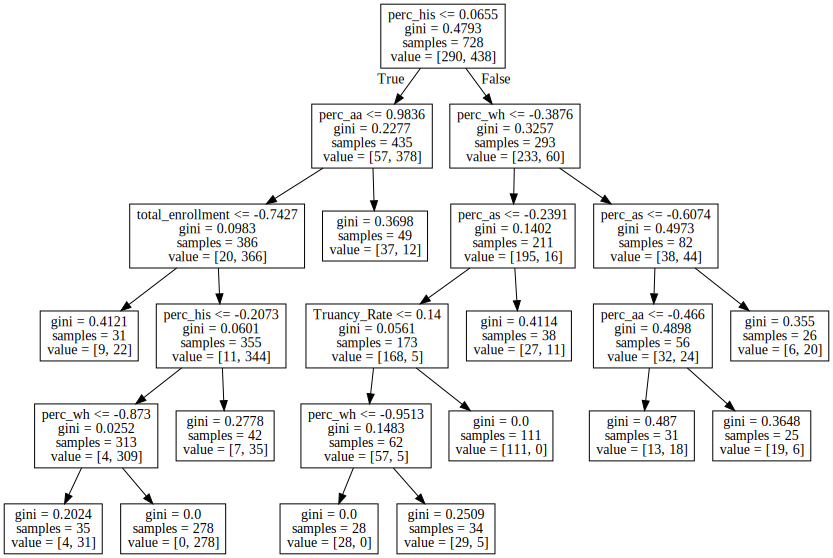

In [189]:
dot_data = externals.six.StringIO()
tree.export_graphviz(dt_model, out_file = dot_data, feature_names = X.columns)
%dotstr dot_data.getvalue()

In [194]:
print "Decision Tree"
print names
print "________________________________________________________________________________________________", "\n"

cv_scores = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='accuracy', cv=10)
#print "Accuracy Scores"
#print cv_scores
print "Accuracy Score mean"
print cv_scores.mean()
print  "________________________________________________________________________________________________", "\n"


#F1 
cv_scores_f1 = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='f1', cv=10)
#print "F1 Scores"
#print cv_scores_f1
print "F1 mean"
print cv_scores_f1.mean()

print  "________________________________________________________________________________________________", "\n"

#total true positive/ true postive (TRUE POSITVE )
cv_scores_recall = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='recall', cv=10)
#print "Recall Scores"
#print cv_scores_recall
print "Recall mean"
print cv_scores_recall.mean()

print "________________________________________________________________________________________________","\n"

# How many true are actual true 
cv_scores_precision = cross_val_score(tree.DecisionTreeClassifier(), X_test, np.ravel(y_test), scoring='precision', cv=10)
#print "Precision Scores"
#print cv_scores_precision
print "Precision mean"
print cv_scores_precision.mean()

Decision Tree
['perc_staff_masters', 'student_teacher', 'avg_years_teaching', 'total_enrollment', 'Truancy_Rate', 'median_income', 'perc_wh', 'perc_aa', 'perc_his', 'perc_as', 'any_virtual']
________________________________________________________________________________________________ 

Accuracy Score mean
0.836111111111
________________________________________________________________________________________________ 

F1 mean
0.867687627492
________________________________________________________________________________________________ 

Recall mean
0.861904761905
________________________________________________________________________________________________ 

Precision mean
0.848580557124
